#I. Import the library

In [ ]:
import os, sys
import re
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


#II. Parameters of model

In [ ]:
BATCH_SIZE = 4
EPOCHS = 7
LSTM_NODES = 256
MAX_SENTENCE_LENGTH = 100
VOCABULARY_SIZE = 5000
VECTOR_DIM = 100

Chatbot model with LSTM

![alt text](https://drive.google.com/uc?id=1qrbO1a7GrK7HR2HGy4V3kPboUEkpb_K8)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#III. Import the preprocess of the Kaggle dataset rDany Chat ( Daily life conversations between humain and robot )

In [ ]:
input_texts = []
target_texts = []
target_texts_inputs = []

with open("/content/drive/My Drive/Chatbot/human_text.txt", encoding="utf8") as textfile1, open("/content/drive/My Drive/Chatbot/robot_text.txt", encoding="utf8") as textfile2:
  for human_text, robot_text in zip(textfile1, textfile2):
    human_text = human_text.strip()
    robot_text = robot_text.strip()

    human_text = re.sub(r'\W', ' ', str(human_text))  #remove punctuations
    robot_text = re.sub(r'\W', ' ', str(robot_text))  
    human_text = re.sub(r'\s+', ' ', human_text, flags=re.I)  #remove extra spaces
    robot_text = re.sub(r'\s+', ' ', robot_text, flags=re.I)

    input_text = human_text
    target_text = robot_text + ' <eos>'
    target_text_input = '<sos> ' + robot_text

    if len(input_text.split()) > MAX_SENTENCE_LENGTH:
      break #ignore sentences longer than expected

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)


print("number of samples:", len(input_texts))
print("An example of Chat:")
print(input_texts[6])
print(target_texts[6])
print(target_texts_inputs[6])

number of samples: 579
An example of Chat:
how old are you how do you look like where do you live 
i m 22 years old i m skinny with brown hair yellow eyes and a big smile i live inside a lab do you like bunnies  <eos>
<sos> i m 22 years old i m skinny with brown hair yellow eyes and a big smile i live inside a lab do you like bunnies 


#IV. Tokenize and pad the sentences

#We convert sentences into integers so that the integers can be used to index the embedding matrix, which contains the vector representation of the word

In [ ]:
tokenizer_inputs = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
word2idx_inputs = tokenizer_inputs.word_index
max_len_input = max(len(s) for s in input_sequences)

tokenizer_outputs = Tokenizer(num_words=VOCABULARY_SIZE ,filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

print(input_sequences[6])
print(input_sequences[8])

[15, 225, 14, 1, 15, 4, 1, 312, 24, 226, 4, 1, 515]
[10, 31, 1, 143, 519, 229, 87, 12, 144, 2, 93, 59, 229, 520, 51, 9, 1, 313, 23, 12, 227]


Clearly not all sentences are of the same size => sequence padding

In [ ]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

#V. Load word embeddings (using glove) and create word embedding matrix

In [ ]:
embedding_dic = {}
with open('/content/drive/My Drive/Chatbot/glove.6B.100d.txt', encoding= "utf8")as vector_list:
  for line in vector_list:
    dimensions = line.split()
    word = dimensions[0]
    vector = np.asarray(dimensions[1:], dtype='float32')
    embedding_dic[word] = vector  #use glove embedding to achieve vector representation

num_words = min(VOCABULARY_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, VECTOR_DIM ))
for word, i in word2idx_inputs.items():
  if i < num_words:
    embedding_vector = embedding_dic.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector  #word embedding for inputs of encoder

num_words_out = min(VOCABULARY_SIZE, len(word2idx_outputs) + 1)
embedding_matrix_out = np.zeros((num_words_out, VECTOR_DIM ))
for word, i in word2idx_outputs.items():
  if i < num_words_out:
    embedding_vector_out = embedding_dic.get(word)
    if embedding_vector_out is not None:
      embedding_matrix_out[i] = embedding_vector_out  #word embedding for decoder inputs & outputs

#VI. Create Input and Output Embedding Layers and Output One Hot Encoded Layer

#Since we are using Softmax function at the output node, our output should be one hot encoded.

In [ ]:
embedding_layer = Embedding(num_words, VECTOR_DIM, weights=[embedding_matrix], 
                            input_length=max_len_input)

embedding_layer_out = Embedding(num_words_out, VECTOR_DIM, 
                                weights=[embedding_matrix_out], 
                                input_length=max_len_target)

decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, 
                                    num_words_output),dtype='float32')

for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1
    decoder_targets_one_hot[i, t, word] = 1

#VII. Construct the model: an encoder LSTM and a decoder LSTM
#We need to create two LSTMs: an encoder LSTM and a decoder LSTM. During training, the input will be passed to encoder, the encoder will generate the hidden and cell states which will be then passed to the decoder. The input to the decoder will be the hidden and cell state from the encoder, along with the target sentence input with <”sos”>  at the beginning. The output will be predicted response. 

The encoder receives   a   sequence   of   input   sentences.   Therefore,   the   shape   of   the   input   is   the“max_len_input” parameter. 
Next, the input passes through the embedding layer. We create the encoder and set its return state to turn. The input passed through the embedding layer is passed to the encoder which returns output, hidden state and cell state. From the encoder, we only need the cell state and hidden state, which we capture in the “encoder_states” list.

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(  LSTM_NODES,  return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

We first define the input place holder for the decoder. Notice the length of the input shape for the input place holder is “max_len_target” which is the length of the longest sentence in target_text list. Next we pass the input placeholder through embedding layer. We then create an LSTM with return_sequences = True since we need output at every point in the decoder. Note that the initial_state of the decoder_lstm is set to encoder_states which consists of the hidden state and cell state of the encoder at the output unit.Eventually, we need to create a dense layer and pass the decoder output to the dense layer.

In [ ]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_inputs_x = embedding_layer_out(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True,)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Create and compile the model with its summary

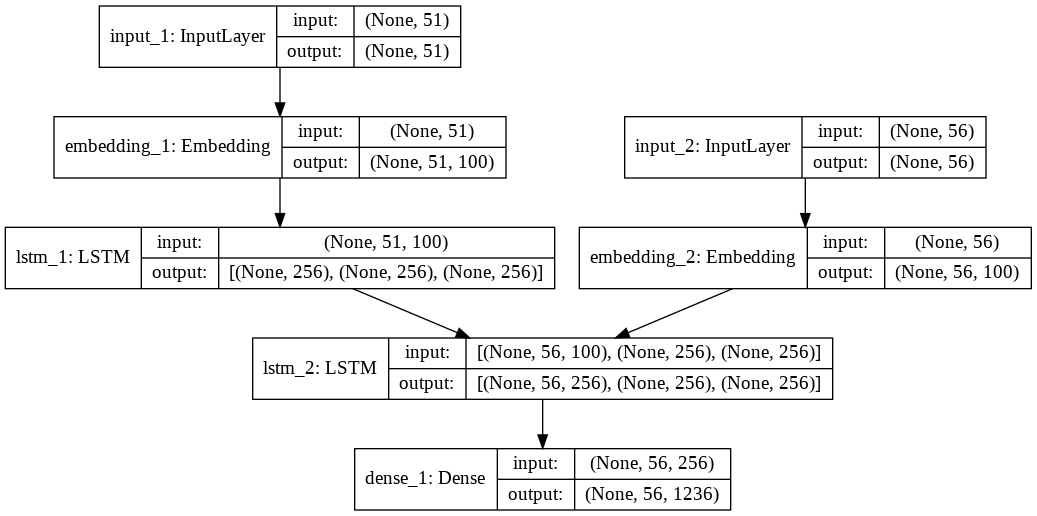

In [ ]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
from keras.utils import plot_model
plot_model(model, to_file='model_plot_enc.png', show_shapes=True,show_layer_names=True)

Fit the model with training data

Final accuracy score: 88.58%

In [ ]:
r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot,
              batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 463 samples, validate on 116 samples
Epoch 1/7
463/463 [==============================] - 31s 68ms/step - loss: 1.3460 - acc: 0.8196 - val_loss: 0.9003 - val_acc: 0.8622
Epoch 2/7
463/463 [==============================] - 29s 64ms/step - loss: 1.0191 - acc: 0.8372 - val_loss: 0.8468 - val_acc: 0.8718
Epoch 3/7
463/463 [==============================] - 30s 65ms/step - loss: 0.9634 - acc: 0.8421 - val_loss: 0.9509 - val_acc: 0.8655
Epoch 4/7
463/463 [==============================] - 29s 63ms/step - loss: 0.9212 - acc: 0.8450 - val_loss: 0.7931 - val_acc: 0.8761
Epoch 5/7
463/463 [==============================] - 30s 64ms/step - loss: 0.8805 - acc: 0.8490 - val_loss: 0.7832 - val_acc: 0.8805
Epoch 6/7
463/463 [==============================] - 30s 64ms/step - loss: 0.8397 - acc: 0.8522 - val_loss: 0.7680 - val_acc: 0.8815
Epoch 7/7
463/463 [==============================] - 30s 64m

VIII. Make predictions
# In the prediction phase we use the same encoder-decoder architecture. Thus, there id no need training the encoders and decoders again. The difference lies in the input parameters. As the illustration shows: 
![alt text](https://drive.google.com/uc?id=1WgkE24Y7nyPaBaYPHJjWm04eq8lqoDII)

The encoder generates the hidden and cell states which acts as inputs of the decoder, along with single word <”sos”>  at the beginning. In the next iteration, the word predicted from the previous decoder LSTM will be taken as input, as well as the hidden and cell state of the decoder. At the end, all the predicted words are concanated together to create final response.

In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
embedding_layer_out_single = Embedding(num_words_out, VECTOR_DIM, 
                                       weights=[embedding_matrix_out],
                                       input_length=1)


There is no need training the encoding model, since we have already trained everything (or to say have updated weights). It remains to take sequence as input and output the final hidden state and cell state of the LSTM for an encoder.
Next, we identify the inputs and outputs of the decoder. In the training phase, the inputs to the decoder were the hidden and cell state from the last LSTM unit of the input sequence and the whole target sequence offset by 1. The output was the corresponding target sequence. During predictions, we no longer have the whole target sequence, which is our aim. Inputs consist of the hidden and cell state from the input sequence and the start of the word for the target sequence. The output of the decoder will be the corresponding target word, the cell state and the hidden state. This cell state and the hidden state, together with the predicted word will be used as input to the next LSTM unit. 

Now we specify the input shape. Since this time, there will be merely one word as input,the shape of input will be 1. We create a new embedding layer which accepts only one word. 

In [ ]:
embedding_layer_out_single = Embedding(num_words_out, VECTOR_DIM, weights=[embedding_matrix_out], input_length=1)
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer_out_single(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x,  initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

The sampling model: 

inputs: y(t-1), h(t-1), c(t-1)

outputs: y(t), h(t), c(t)

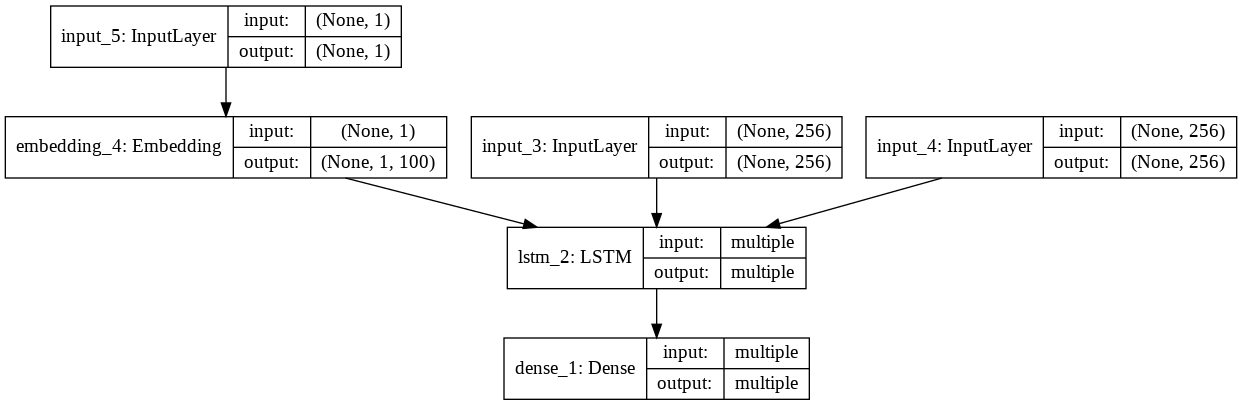

In [ ]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In the preprocessing steps, we converted words to integers. The output of our model should be an integer. We are therefore interested in dictionaries where key is the integer and thevalue is the word that corresponds to the integer.

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

Eventually, we define a function that takes in the input sequence, and returns the output sequence.

In [ ]:
def generate_response(input_seq):
  #Encode the input as state vectors
  states_value = encoder_model.predict(input_seq)
  #Initialize empty target sequence of length 1
  target_seq = np.zeros((1, 1))
  #Start from 'sos'
  target_seq[0, 0] = word2idx_outputs['<sos>']

  eos = word2idx_outputs['<eos>']

  output_sentence = []
  for _ in range(max_len_target):
    #probability distribution of all the possible words + the hidden state + cell state
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    #Find new word
    idx = np.argmax(output_tokens[0, 0, :])
    # when next word = End of sentence exit the loop
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_target[idx]
      output_sentence.append(word)
    #Update decoder input + states
    target_seq[0, 0] = idx
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [ ]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  resp = generate_response(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Response:', resp)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: i had dantinst surgery i told you what do you mean ordering my place a bit 
Response: i can t t have my but i can call me can be a bot
Continue? [Y/n]Y
-
Input: i read this what do you think aboud chinese room argument against ai 
Response: i can t t have a but but i can be a bit of the of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Continue? [Y/n]Y
-
Input: oh charging station in the fridge i see some keep their brains there do you play games seeing you re a wikipedia fan maybe you should edit yourself in i suggest you start there https en wikipedia org wiki intelligent_personal_assistant comparison_of_assistants
Response: i can t t have a bit but i can be be a bot
Continue? [Y/n]Y
-
Input: so if my bot can upderstand 10 commands i should add 10 buttons or how it works 
Response: i can t t my but i can call me can me can me
Continue? [Y/n]Y
-
Input: you are stud